# Visualize Felzenswalb Segmentation

In [8]:
from torchvision import transforms
import albumentations as A

import sys
sys.path.append('.')

from data.CTDataSet import CTDicomSlicesFelzSaving, CTDicomSlicesJigsaw
from data.CustomTransforms import Window, Imagify, MinDimension
from models.ResNet_jigsaw import ResnetJigsaw
from constants import Constants
from run_model import get_dl_workers
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import SimpleITK as sitk
import torch

In [9]:
WL = 50
WW = 200
size = 256

prep = transforms.Compose([Window(WL, WW), Imagify(WL, WW)])
resize_tsfm = MinDimension(size)
tsfm = A.CenterCrop(size, size, always_apply=True, p=1.0)

In [10]:
def create_dataloader(pretrain_task :str = "felz"):
    dataset = "/mnt/d/thesis/ct_only_filtered_2/cetuximab/1"
    dcm_list = CTDicomSlicesJigsaw.generate_file_list(dataset, dicom_glob='/*.dcm')

    print(dcm_list)

    if pretrain_task == "felz":
        ctds = CTDicomSlicesFelzSaving(dcm_list, preprocessing=prep, transform=tsfm, resize_transform = resize_tsfm, felz_crop=True, single_foreground=False)

    elif pretrain_task == "jigsaw":
        ctds = CTDicomSlicesJigsaw(dcm_list, preprocessing=prep, return_tile_coords=True, 
            perm_path=None, n_shuffles_per_image=1, num_perms=None, tile_normalize=False)
        
    else:
        raise Exception("Invalid pretrain_task value of '{}'\n".format(pretrain_task))
       
    return DataLoader(ctds, batch_size=1, num_workers=0, shuffle=False)


In [11]:
def plot_slices_and_mask(slices, mask, raw_img, segments = None, super_pixels = None):
    mask = mask * 255

    fig = plt.figure(figsize=(15,20))
    cols, rows = 2, 3

    plt.suptitle("Segmentation Pretraining Task", fontsize=16, fontweight='bold')

    fig.add_subplot(rows, cols, 1)
    plt.imshow(raw_img)
    plt.title("A. Original image")

    cur_slice = np.expand_dims(slices[0, :, :, 0], -1)
    cur_slice = np.concatenate((cur_slice, cur_slice, cur_slice), axis=-1)

    cur_slice = prep(cur_slice)

    fig.add_subplot(rows, cols, 2)
    plt.imshow(cur_slice)
    plt.title("B. Center-cropped image")

    fig.add_subplot(rows, cols, 3)
    segments = segments.numpy()
    plt.imshow(np.moveaxis(segments, 0, -1))
    plt.scatter(super_pixels[0,:,0], super_pixels[0,:,1], color='red', marker='o', s=100, label='Datapoints')
    plt.title("C. All segments")

    fig.add_subplot(rows, cols, 4)
    plt.imshow(mask[0], cmap='gray')
    plt.scatter(super_pixels[0,:,0], super_pixels[0,:,1], color='red', marker='o', s=100, label='Datapoints')
    plt.title("D. Label mask (5 foreground segs)")

    fig.add_subplot(rows, cols, 5)

    # mask has 5 segments of different colors. make them all foreground = 1
    foregound_mask = np.where(mask[0]!=0, 1, 0)

    plt.imshow(foregound_mask, cmap='gray')
    plt.scatter(super_pixels[0,:,0], super_pixels[0,:,1], color='red', marker='o', s=100, label='Datapoints')
    plt.title("E. Label mask (1 foreground seg)")

    plt.show()

In [12]:
def get_raw_image(img_path):
    img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))

    img = np.moveaxis(img, 0, -1)
    img = np.concatenate((img, img, img), axis=-1)

    img = prep(img)

    return img

In [13]:
def plot_slice_and_tiles(image, tiles, coords):
    fig = plt.figure(figsize=(15,15))
    cols, rows = 2, 1

    plt.suptitle("Jigsaw Pretraining Task", fontsize=16, fontweight='bold')

    cur_slice = np.expand_dims(image[0, :, :, 0], -1)
    cur_slice = np.concatenate((cur_slice, cur_slice, cur_slice), axis=-1)

    subplt = fig.add_subplot(rows, cols, 1)

    #print("coords [0, 4, :, :] = {}\n".format(coords[0][0, 4]))

    #plt.imshow(cur_slice[coords[4]])
    #print("cur_slice.size = {}\n".format(cur_slice.shape))

    #tile_tl = coords[4][0]
    #tile_br = tile_tl + 64

    #print("tile_tl: {} - tile_br: {}\n".format(tile_tl, tile_br))

    #y = tile_tl[1]

    #single_tile = cur_slice[tile_tl[0]:tile_br[0], tile_tl[1]:tile_br[1], :]

    #print("coords: {}\n".format(coords))

    #plt.imshow(single_tile)

    plt.imshow(cur_slice)
    for c in coords:
        c_prime = c[0]
        #c_prime[1] = image.size()[2] - c_prime[1]
        print("c_prime is: {}\n".format(c_prime))

        rect = patches.Rectangle(c_prime.numpy(), 64, 64, linewidth=3, edgecolor='g', facecolor='none')
        subplt.add_patch(rect)
    plt.title("A. Preprocessed input image")

    #crop = A.Crop(coords[0][0, 0], coords[0][0, 1], coords[-1][0, 0], coords[-1][0,1])

    #cur_slice = cur_slice.astype("float")

    #cur_slice = crop(image=cur_slice.astype("float"))["image"].astype("int")

    fig.add_subplot(rows, cols, 2)

    print(tiles[:,0,:,:,:].size())

    tiles_together = ResnetJigsaw.tiles_to_image(tiles[:,0,:,:,:], in_channels=3)[0].numpy()
    tiles_together = np.moveaxis(tiles_together, 0, -1)
    tiles_together = prep(tiles_together)

    single_tile = tiles[0, 0, 4, :, :]
    #print("single_tile size: {}".format(tiles.size()))

    plt.imshow(tiles_together)
    #plt.imshow(single_tile)
    plt.title("B. Selected tiles")

    plt.show()

['/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/1.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/10.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/100.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/101.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/102.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/103.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/104.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/105.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/106.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/107.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/108.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/109.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/11.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/110.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/111.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/112.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/113.dcm', '/mnt/d/thesis/ct_only_filtered_2/cetuximab/1/12.dc

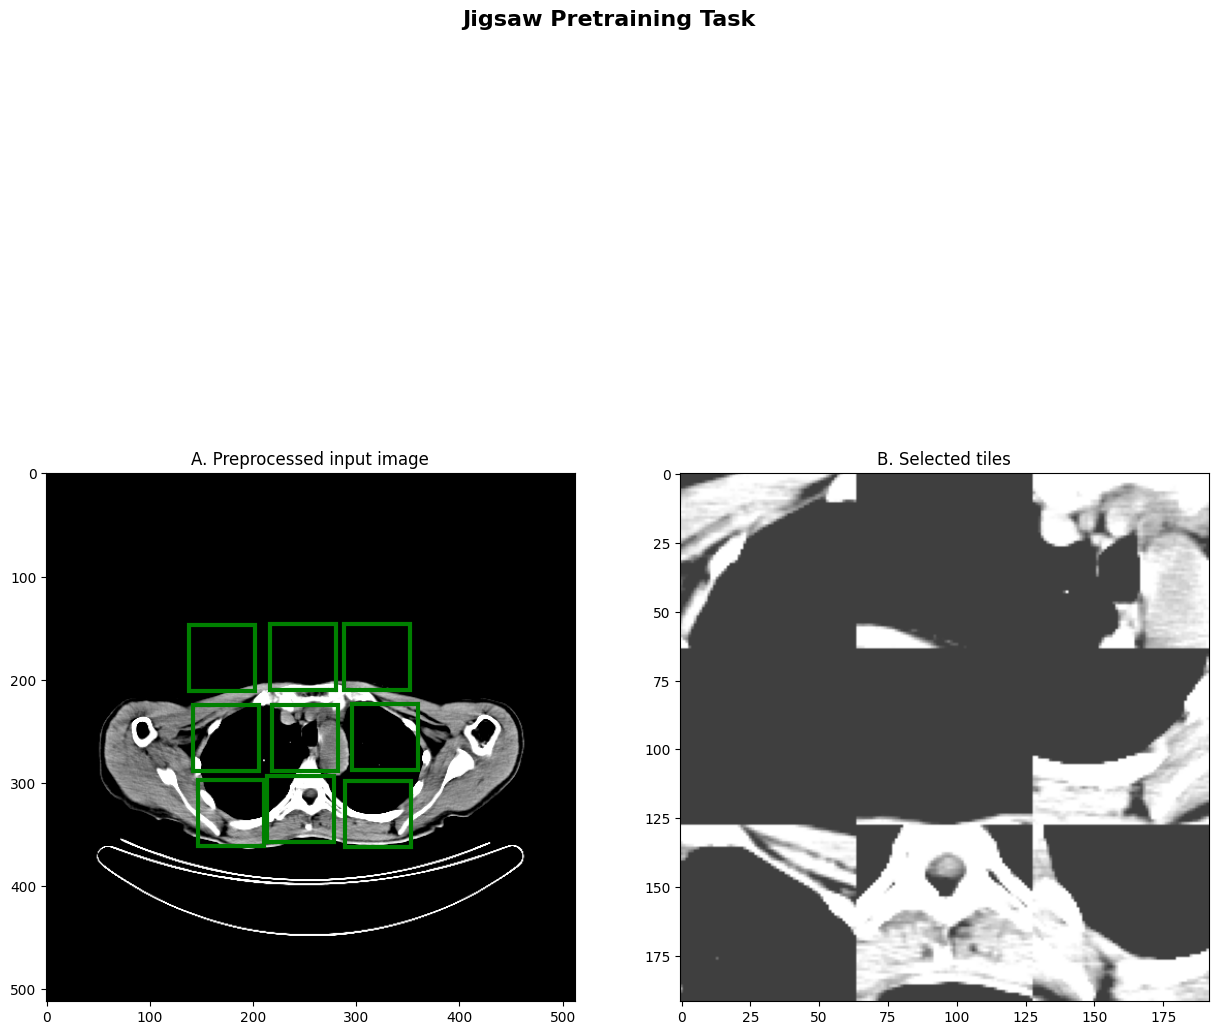

tile top left: [131 138] -- tile bottom right: [195 202]

tile top left: [139 213] -- tile bottom right: [203 277]

tile top left: [131 286] -- tile bottom right: [195 350]

tile top left: [210 136] -- tile bottom right: [274 200]

tile top left: [206 217] -- tile bottom right: [270 281]

tile top left: [213 293] -- tile bottom right: [277 357]

tile top left: [284 134] -- tile bottom right: [348 198]

tile top left: [286 214] -- tile bottom right: [350 278]

tile top left: [284 285] -- tile bottom right: [348 349]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([131, 138])

c_prime is: tensor([139, 213])

c_prime is: tensor([131, 286])

c_prime is: tensor([210, 136])

c_prime is: tensor([206, 217])

c_prime is: tensor([213, 293])

c_prime is: tensor([284, 134])

c_prime is: tensor([286, 214])

c_prime is: tensor([284, 285])

torch.Size([1, 9, 64, 64])


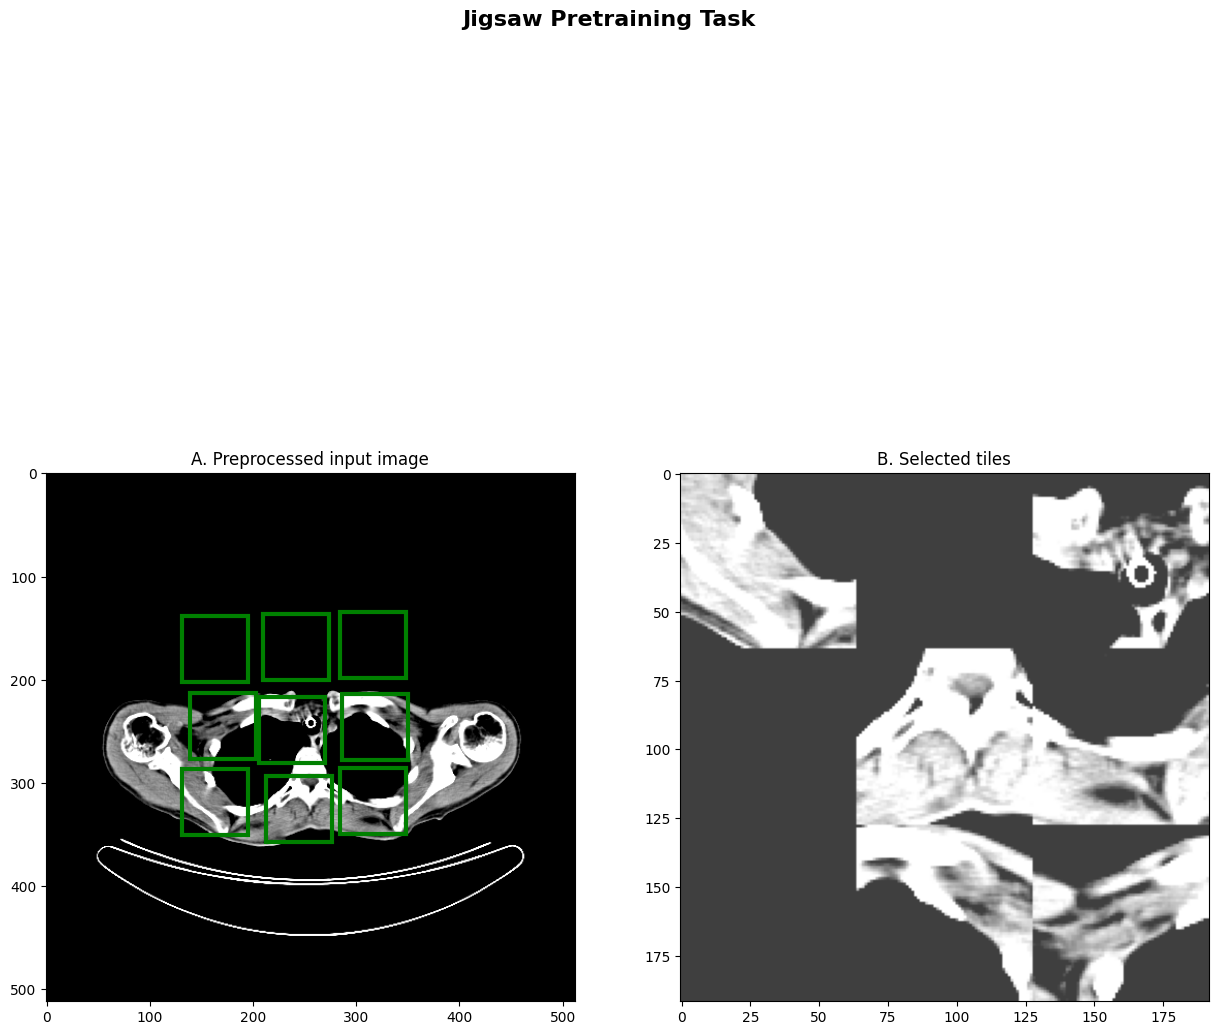

tile top left: [159 150] -- tile bottom right: [223 214]

tile top left: [159 231] -- tile bottom right: [223 295]

tile top left: [151 302] -- tile bottom right: [215 366]

tile top left: [227 149] -- tile bottom right: [291 213]

tile top left: [227 232] -- tile bottom right: [291 296]

tile top left: [230 299] -- tile bottom right: [294 363]

tile top left: [310 149] -- tile bottom right: [374 213]

tile top left: [301 222] -- tile bottom right: [365 286]

tile top left: [301 303] -- tile bottom right: [365 367]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([159, 150])

c_prime is: tensor([159, 231])

c_prime is: tensor([151, 302])

c_prime is: tensor([227, 149])

c_prime is: tensor([227, 232])

c_prime is: tensor([230, 299])

c_prime is: tensor([310, 149])

c_prime is: tensor([301, 222])

c_prime is: tensor([301, 303])

torch.Size([1, 9, 64, 64])


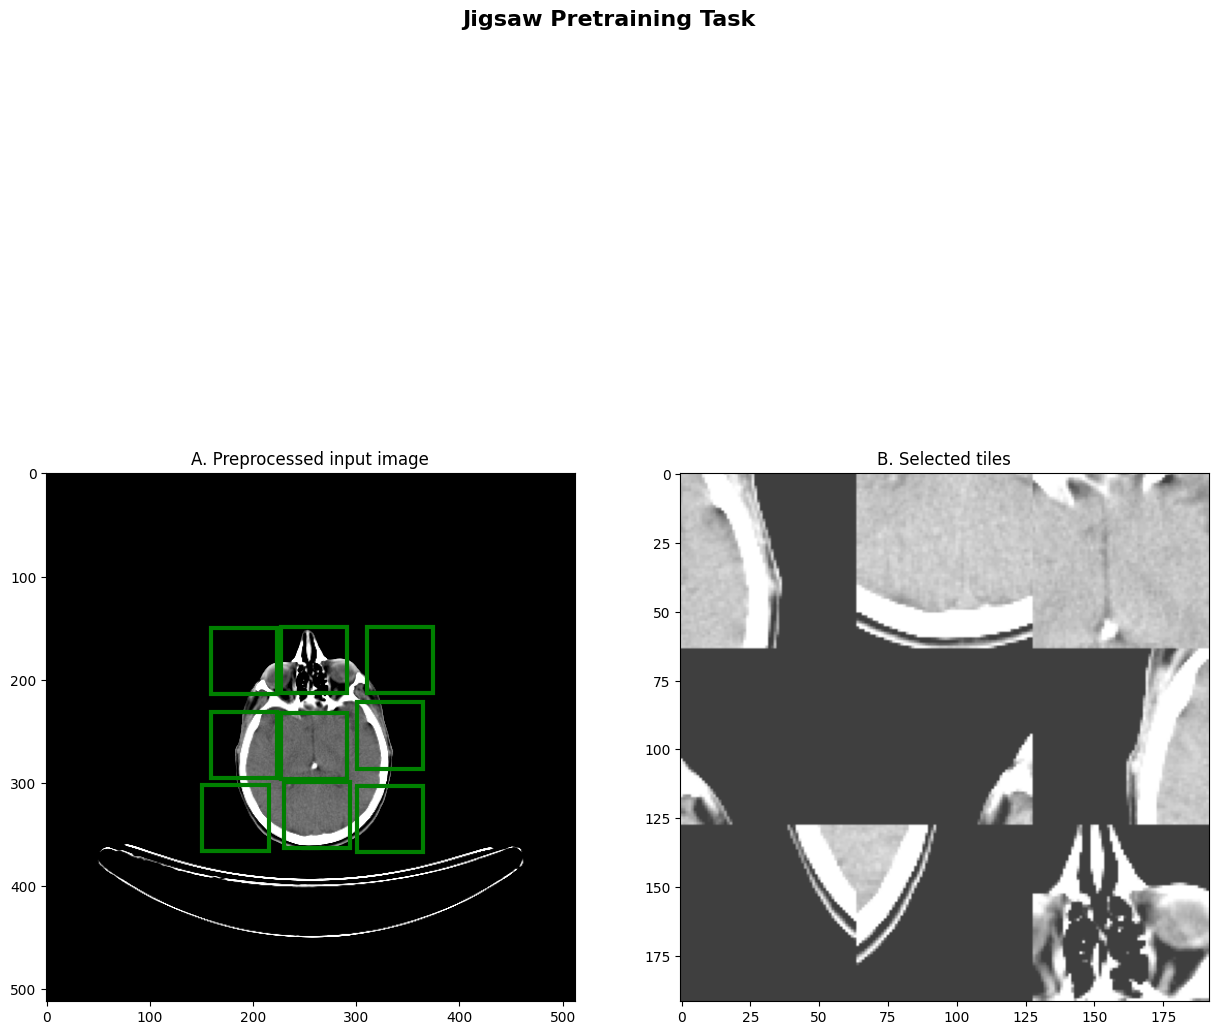

tile top left: [144 161] -- tile bottom right: [208 225]

tile top left: [142 231] -- tile bottom right: [206 295]

tile top left: [137 306] -- tile bottom right: [201 370]

tile top left: [215 160] -- tile bottom right: [279 224]

tile top left: [216 230] -- tile bottom right: [280 294]

tile top left: [220 306] -- tile bottom right: [284 370]

tile top left: [291 155] -- tile bottom right: [355 219]

tile top left: [292 237] -- tile bottom right: [356 301]

tile top left: [295 307] -- tile bottom right: [359 371]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([144, 161])

c_prime is: tensor([142, 231])

c_prime is: tensor([137, 306])

c_prime is: tensor([215, 160])

c_prime is: tensor([216, 230])

c_prime is: tensor([220, 306])

c_prime is: tensor([291, 155])

c_prime is: tensor([292, 237])

c_prime is: tensor([295, 307])

torch.Size([1, 9, 64, 64])


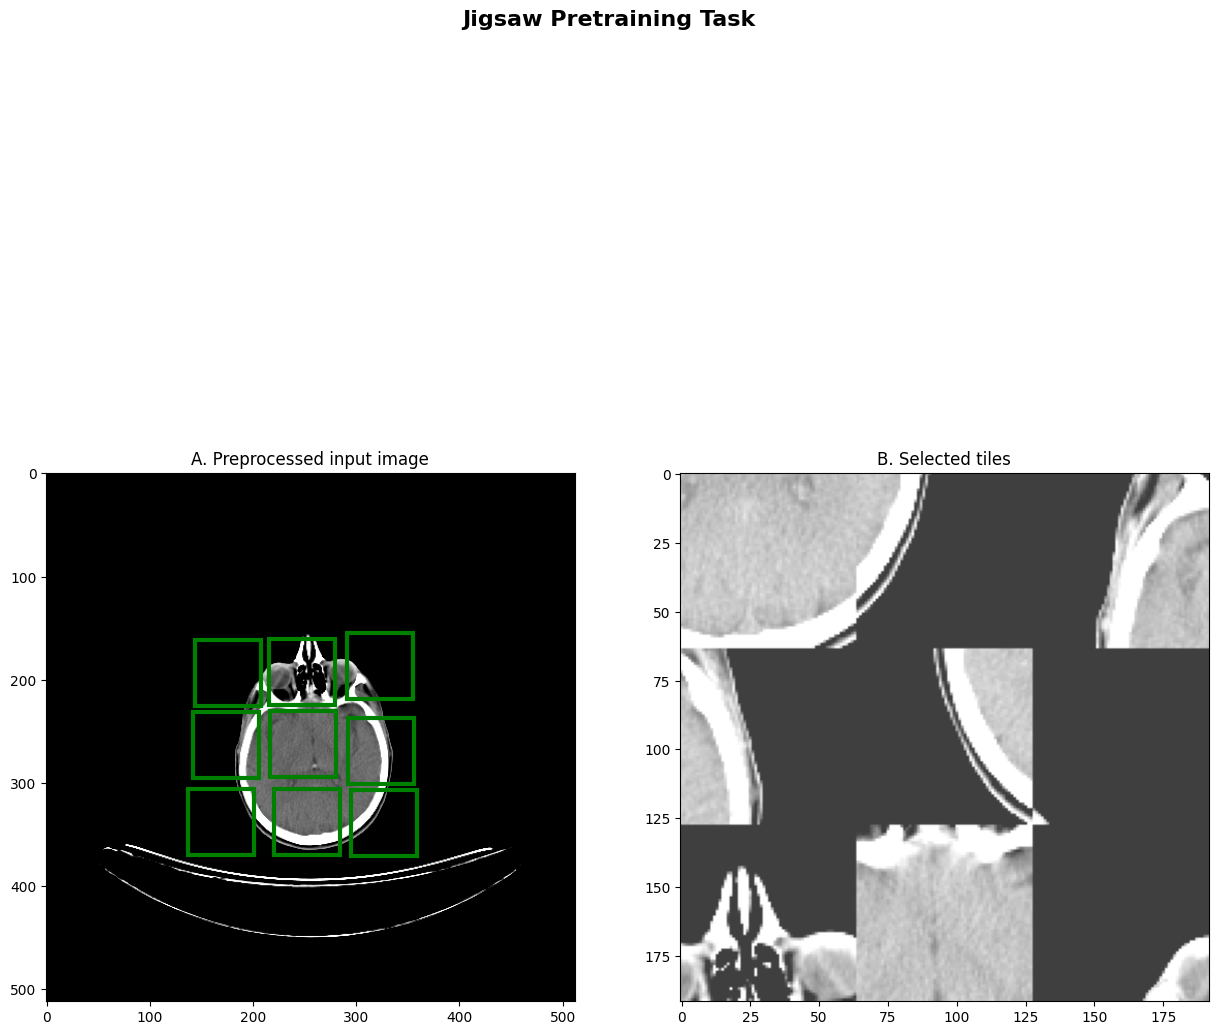

tile top left: [140 139] -- tile bottom right: [204 203]

tile top left: [137 216] -- tile bottom right: [201 280]

tile top left: [140 286] -- tile bottom right: [204 350]

tile top left: [206 137] -- tile bottom right: [270 201]

tile top left: [216 212] -- tile bottom right: [280 276]

tile top left: [207 295] -- tile bottom right: [271 359]

tile top left: [281 144] -- tile bottom right: [345 208]

tile top left: [292 210] -- tile bottom right: [356 274]

tile top left: [283 294] -- tile bottom right: [347 358]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([140, 139])

c_prime is: tensor([137, 216])

c_prime is: tensor([140, 286])

c_prime is: tensor([206, 137])

c_prime is: tensor([216, 212])

c_prime is: tensor([207, 295])

c_prime is: tensor([281, 144])

c_prime is: tensor([292, 210])

c_prime is: tensor([283, 294])

torch.Size([1, 9, 64, 64])


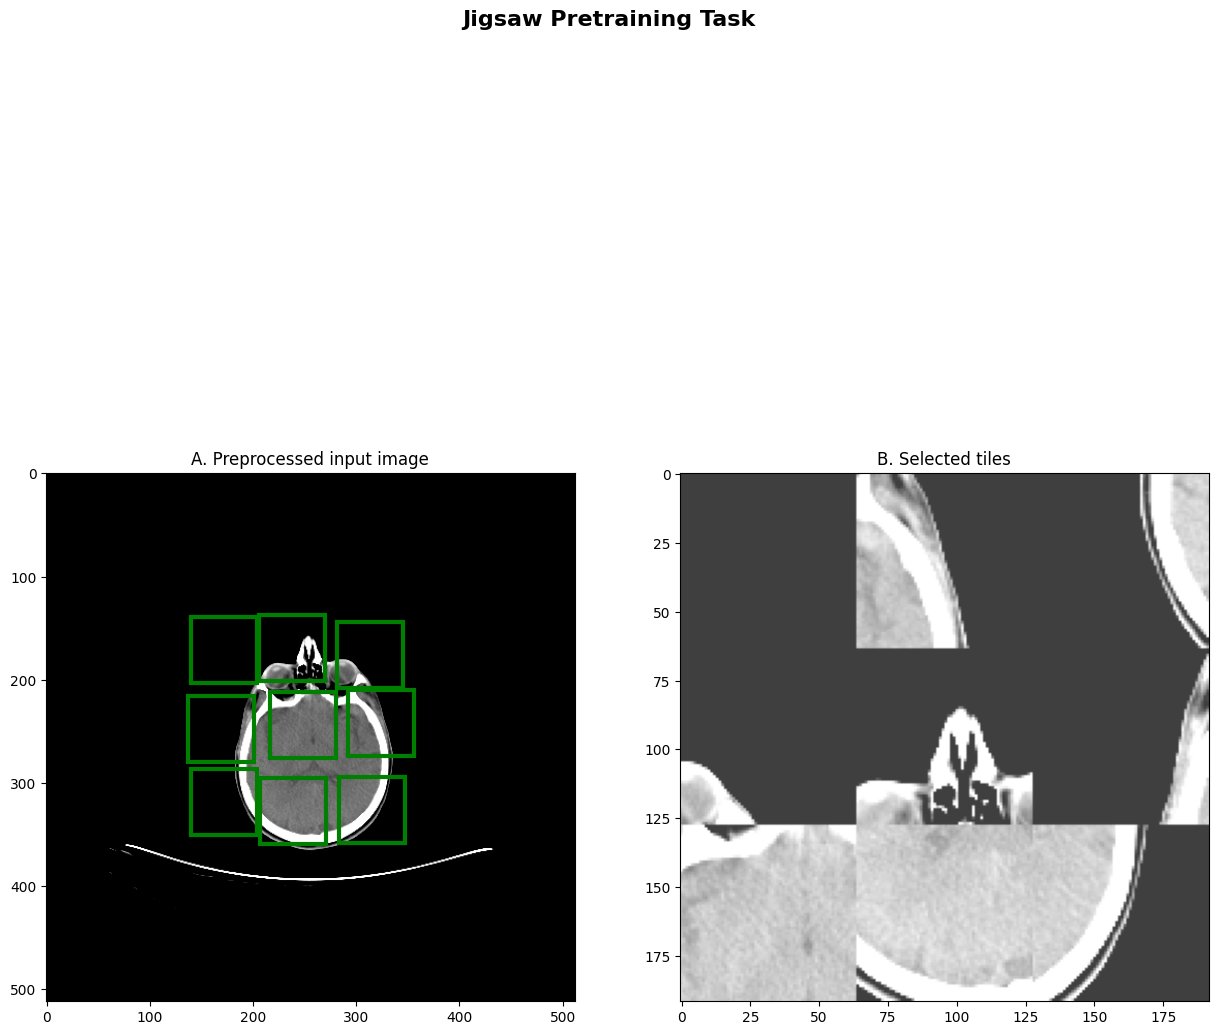

tile top left: [155 160] -- tile bottom right: [219 224]

tile top left: [157 234] -- tile bottom right: [221 298]

tile top left: [154 316] -- tile bottom right: [218 380]

tile top left: [226 161] -- tile bottom right: [290 225]

tile top left: [226 241] -- tile bottom right: [290 305]

tile top left: [226 311] -- tile bottom right: [290 375]

tile top left: [308 158] -- tile bottom right: [372 222]

tile top left: [305 238] -- tile bottom right: [369 302]

tile top left: [306 310] -- tile bottom right: [370 374]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([155, 160])

c_prime is: tensor([157, 234])

c_prime is: tensor([154, 316])

c_prime is: tensor([226, 161])

c_prime is: tensor([226, 241])

c_prime is: tensor([226, 311])

c_prime is: tensor([308, 158])

c_prime is: tensor([305, 238])

c_prime is: tensor([306, 310])

torch.Size([1, 9, 64, 64])


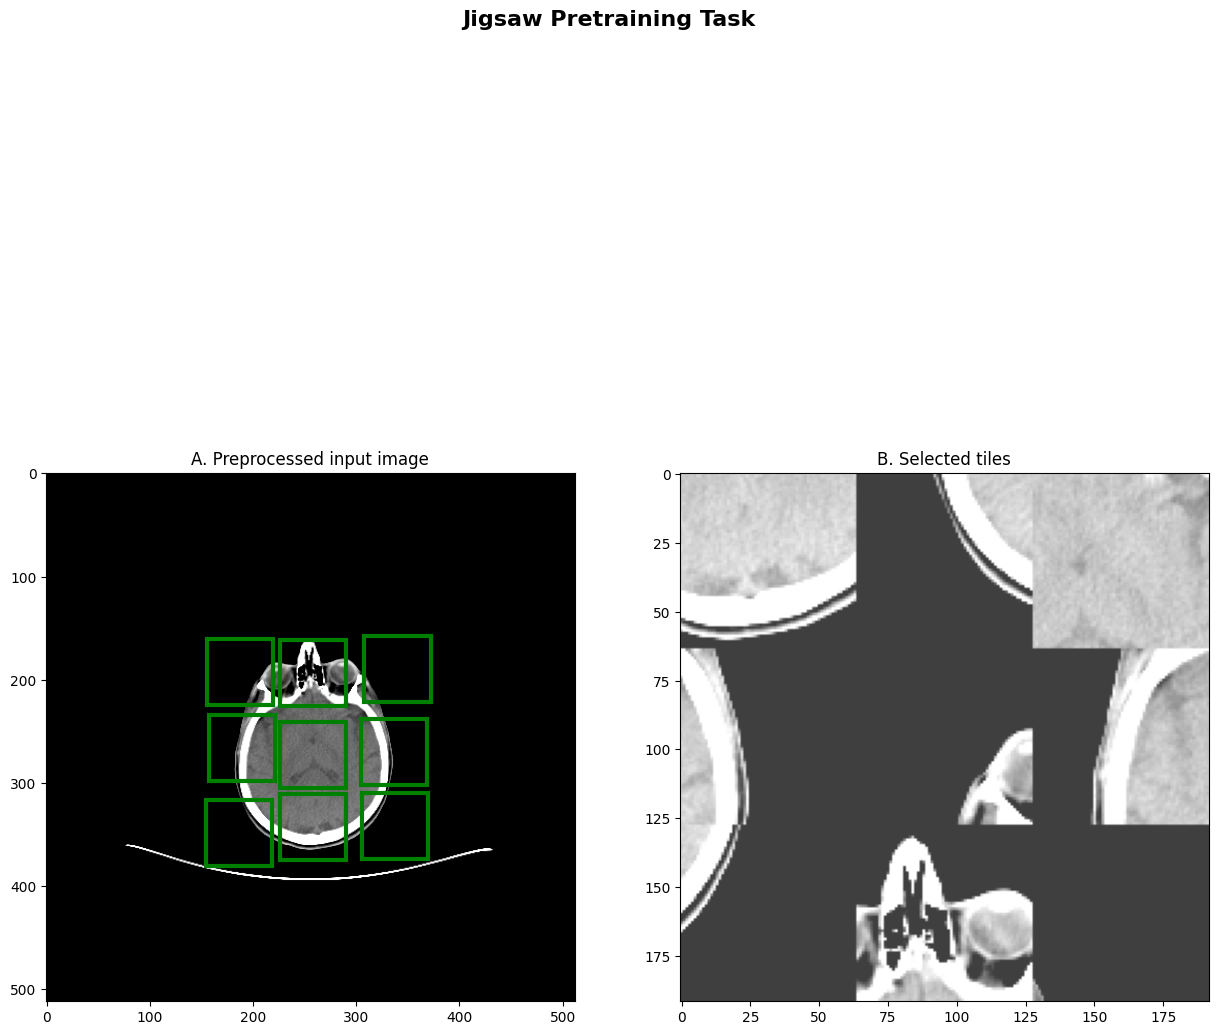

tile top left: [136 144] -- tile bottom right: [200 208]

tile top left: [140 224] -- tile bottom right: [204 288]

tile top left: [131 292] -- tile bottom right: [195 356]

tile top left: [210 144] -- tile bottom right: [274 208]

tile top left: [215 225] -- tile bottom right: [279 289]

tile top left: [207 292] -- tile bottom right: [271 356]

tile top left: [286 141] -- tile bottom right: [350 205]

tile top left: [283 227] -- tile bottom right: [347 291]

tile top left: [287 293] -- tile bottom right: [351 357]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([136, 144])

c_prime is: tensor([140, 224])

c_prime is: tensor([131, 292])

c_prime is: tensor([210, 144])

c_prime is: tensor([215, 225])

c_prime is: tensor([207, 292])

c_prime is: tensor([286, 141])

c_prime is: tensor([283, 227])

c_prime is: tensor([287, 293])

torch.Size([1, 9, 64, 64])


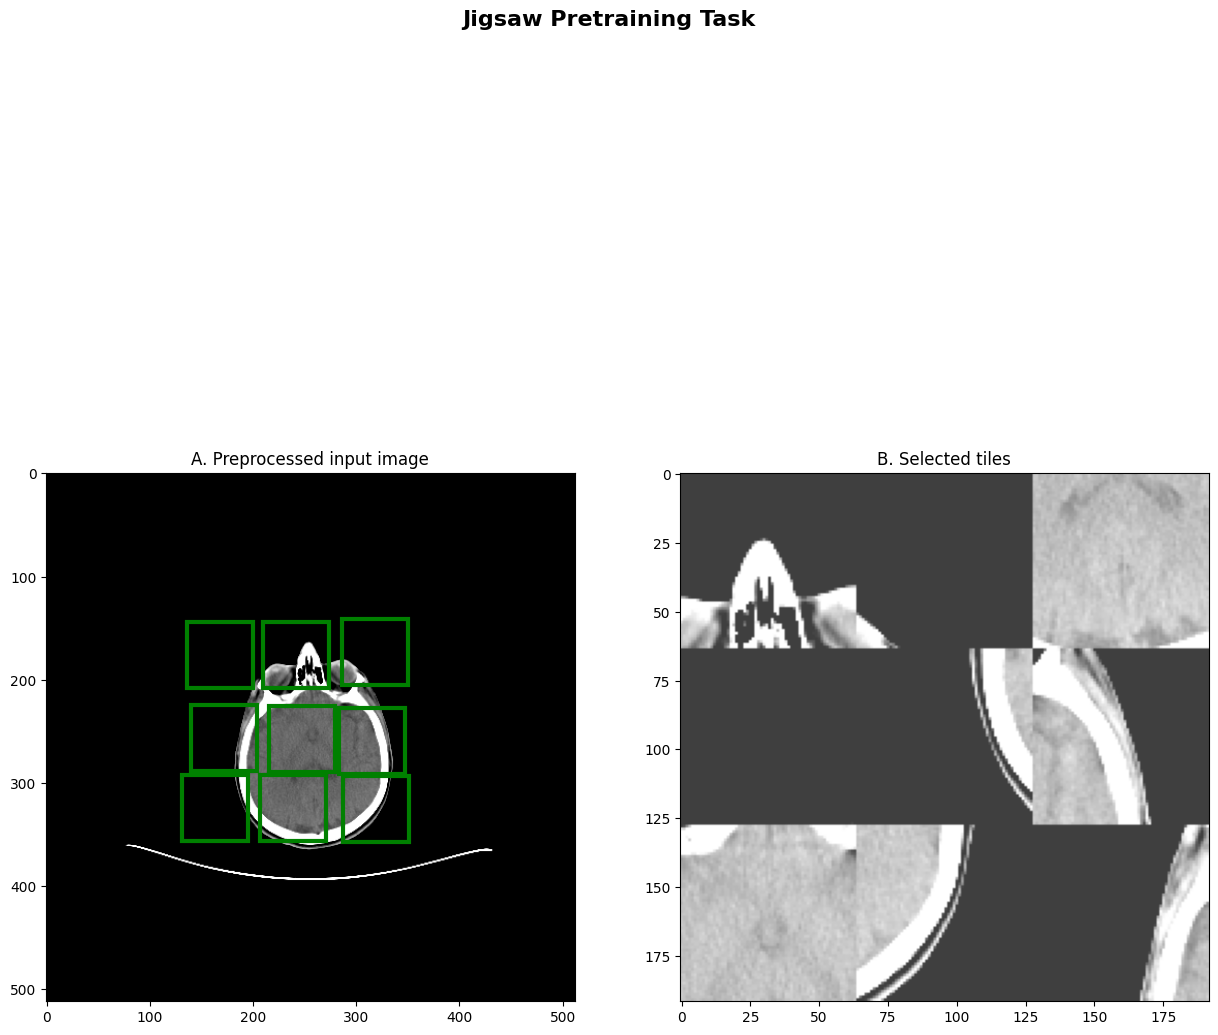

tile top left: [158 141] -- tile bottom right: [222 205]

tile top left: [158 224] -- tile bottom right: [222 288]

tile top left: [165 296] -- tile bottom right: [229 360]

tile top left: [232 143] -- tile bottom right: [296 207]

tile top left: [239 220] -- tile bottom right: [303 284]

tile top left: [242 299] -- tile bottom right: [306 363]

tile top left: [314 143] -- tile bottom right: [378 207]

tile top left: [310 222] -- tile bottom right: [374 286]

tile top left: [316 298] -- tile bottom right: [380 362]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([158, 141])

c_prime is: tensor([158, 224])

c_prime is: tensor([165, 296])

c_prime is: tensor([232, 143])

c_prime is: tensor([239, 220])

c_prime is: tensor([242, 299])

c_prime is: tensor([314, 143])

c_prime is: tensor([310, 222])

c_prime is: tensor([316, 298])

torch.Size([1, 9, 64, 64])


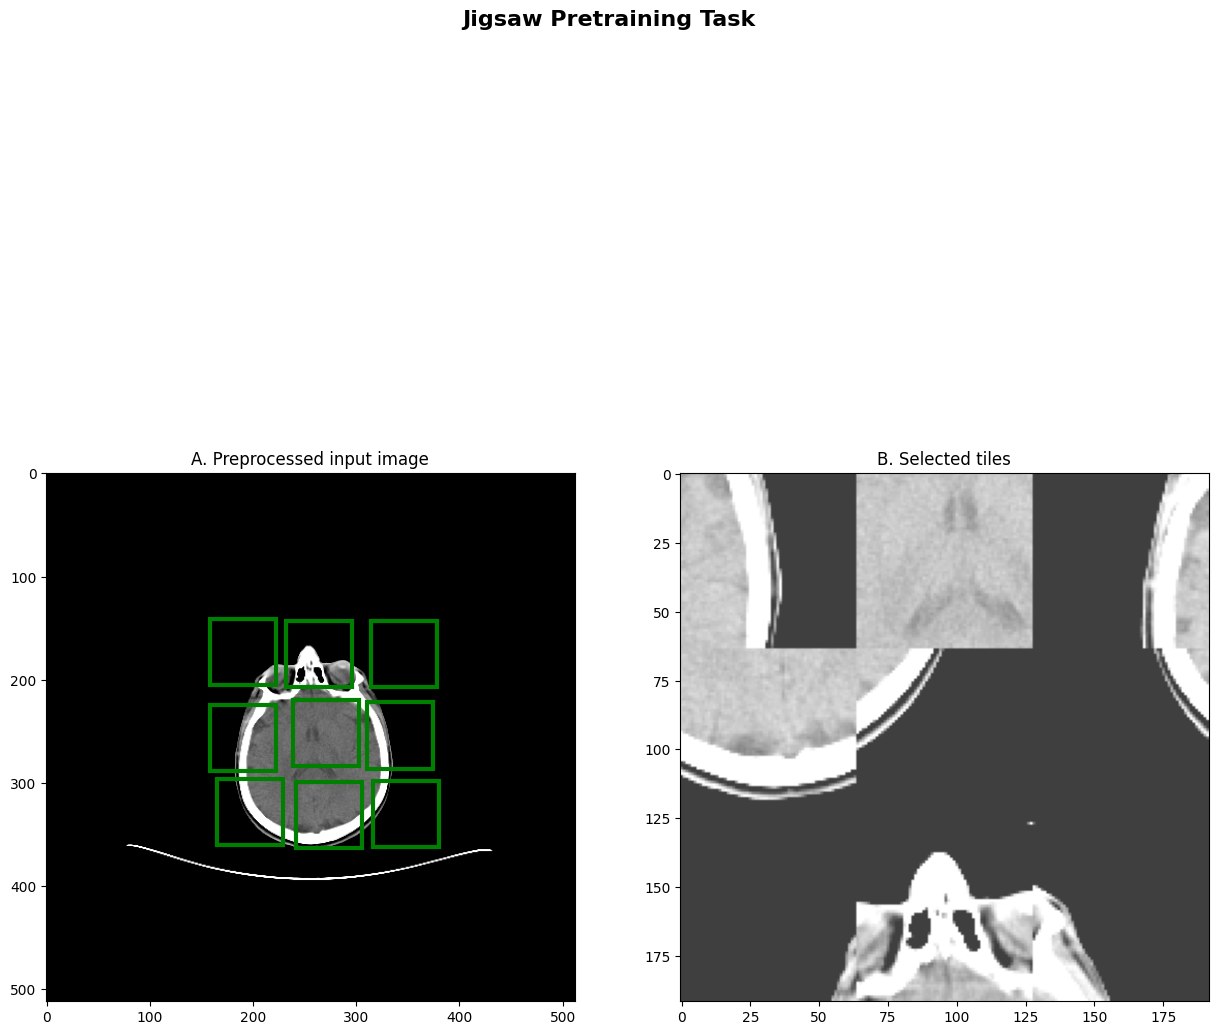

tile top left: [162 135] -- tile bottom right: [226 199]

tile top left: [164 219] -- tile bottom right: [228 283]

tile top left: [162 291] -- tile bottom right: [226 355]

tile top left: [234 142] -- tile bottom right: [298 206]

tile top left: [236 220] -- tile bottom right: [300 284]

tile top left: [238 295] -- tile bottom right: [302 359]

tile top left: [307 144] -- tile bottom right: [371 208]

tile top left: [308 216] -- tile bottom right: [372 280]

tile top left: [311 290] -- tile bottom right: [375 354]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([162, 135])

c_prime is: tensor([164, 219])

c_prime is: tensor([162, 291])

c_prime is: tensor([234, 142])

c_prime is: tensor([236, 220])

c_prime is: tensor([238, 295])

c_prime is: tensor([307, 144])

c_prime is: tensor([308, 216])

c_prime is: tensor([311, 290])

torch.Size([1, 9, 64, 64])


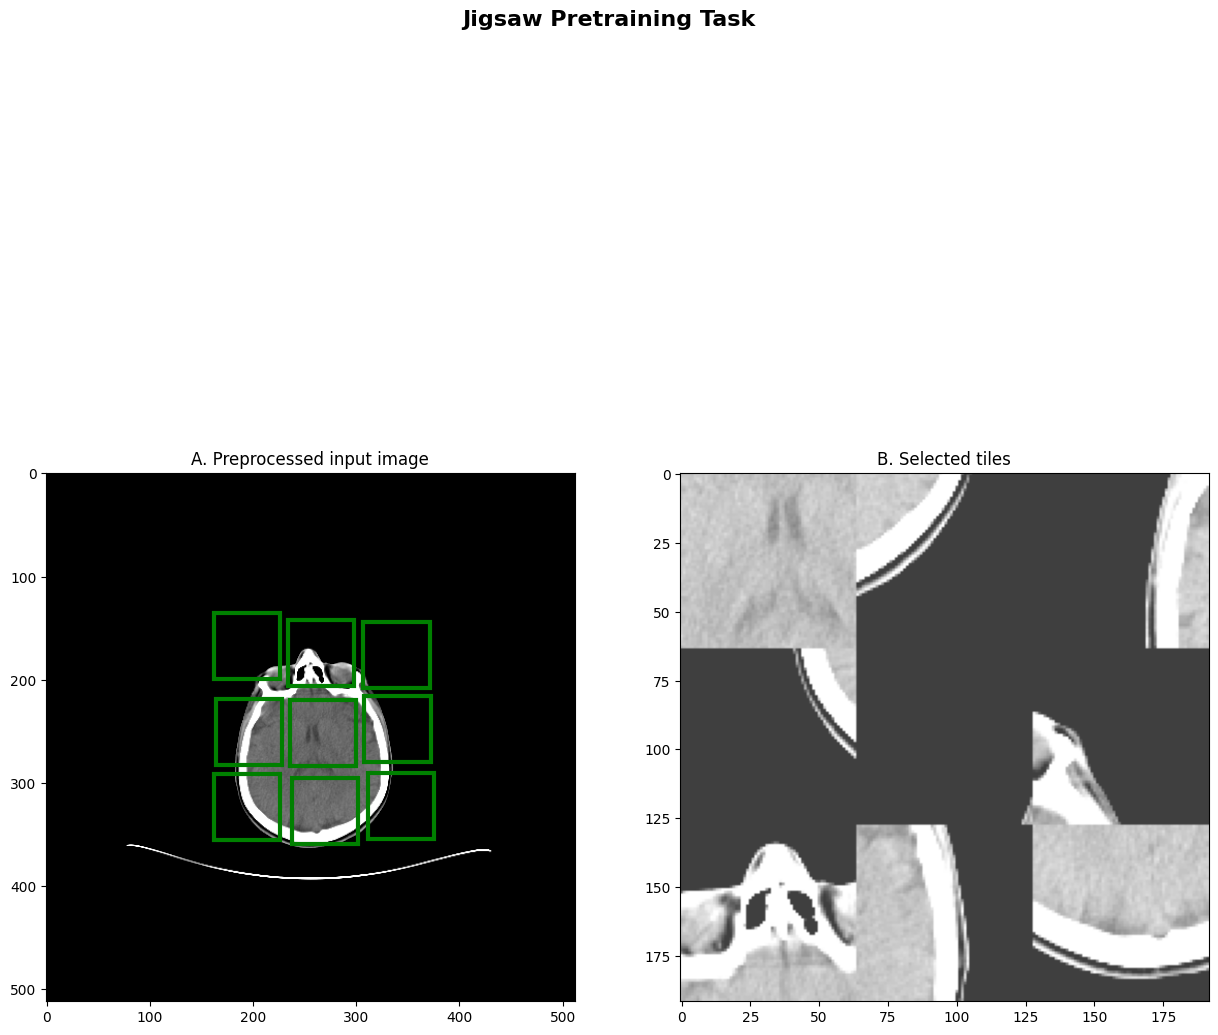

tile top left: [146 152] -- tile bottom right: [210 216]

tile top left: [157 221] -- tile bottom right: [221 285]

tile top left: [146 294] -- tile bottom right: [210 358]

tile top left: [222 152] -- tile bottom right: [286 216]

tile top left: [230 226] -- tile bottom right: [294 290]

tile top left: [222 300] -- tile bottom right: [286 364]

tile top left: [298 152] -- tile bottom right: [362 216]

tile top left: [300 226] -- tile bottom right: [364 290]

tile top left: [304 297] -- tile bottom right: [368 361]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([146, 152])

c_prime is: tensor([157, 221])

c_prime is: tensor([146, 294])

c_prime is: tensor([222, 152])

c_prime is: tensor([230, 226])

c_prime is: tensor([222, 300])

c_prime is: tensor([298, 152])

c_prime is: tensor([300, 226])

c_prime is: tensor([304, 297])

torch.Size([1, 9, 64, 64])


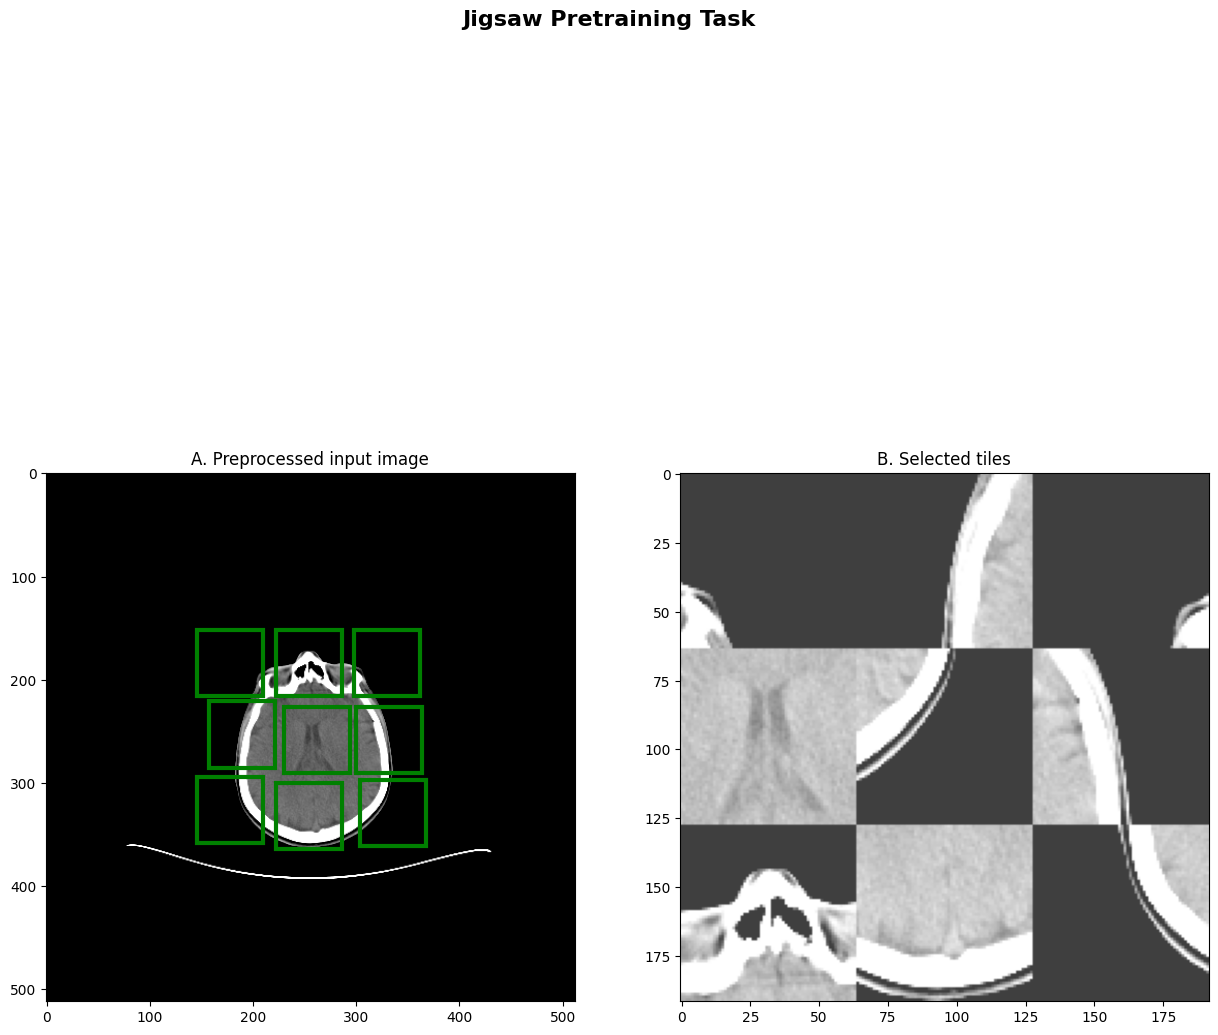

tile top left: [160 149] -- tile bottom right: [224 213]

tile top left: [157 231] -- tile bottom right: [221 295]

tile top left: [167 300] -- tile bottom right: [231 364]

tile top left: [234 151] -- tile bottom right: [298 215]

tile top left: [238 222] -- tile bottom right: [302 286]

tile top left: [236 297] -- tile bottom right: [300 361]

tile top left: [315 148] -- tile bottom right: [379 212]

tile top left: [317 221] -- tile bottom right: [381 285]

tile top left: [307 305] -- tile bottom right: [371 369]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([160, 149])

c_prime is: tensor([157, 231])

c_prime is: tensor([167, 300])

c_prime is: tensor([234, 151])

c_prime is: tensor([238, 222])

c_prime is: tensor([236, 297])

c_prime is: tensor([315, 148])

c_prime is: tensor([317, 221])

c_prime is: tensor([307, 305])

torch.Size([1, 9, 64, 64])


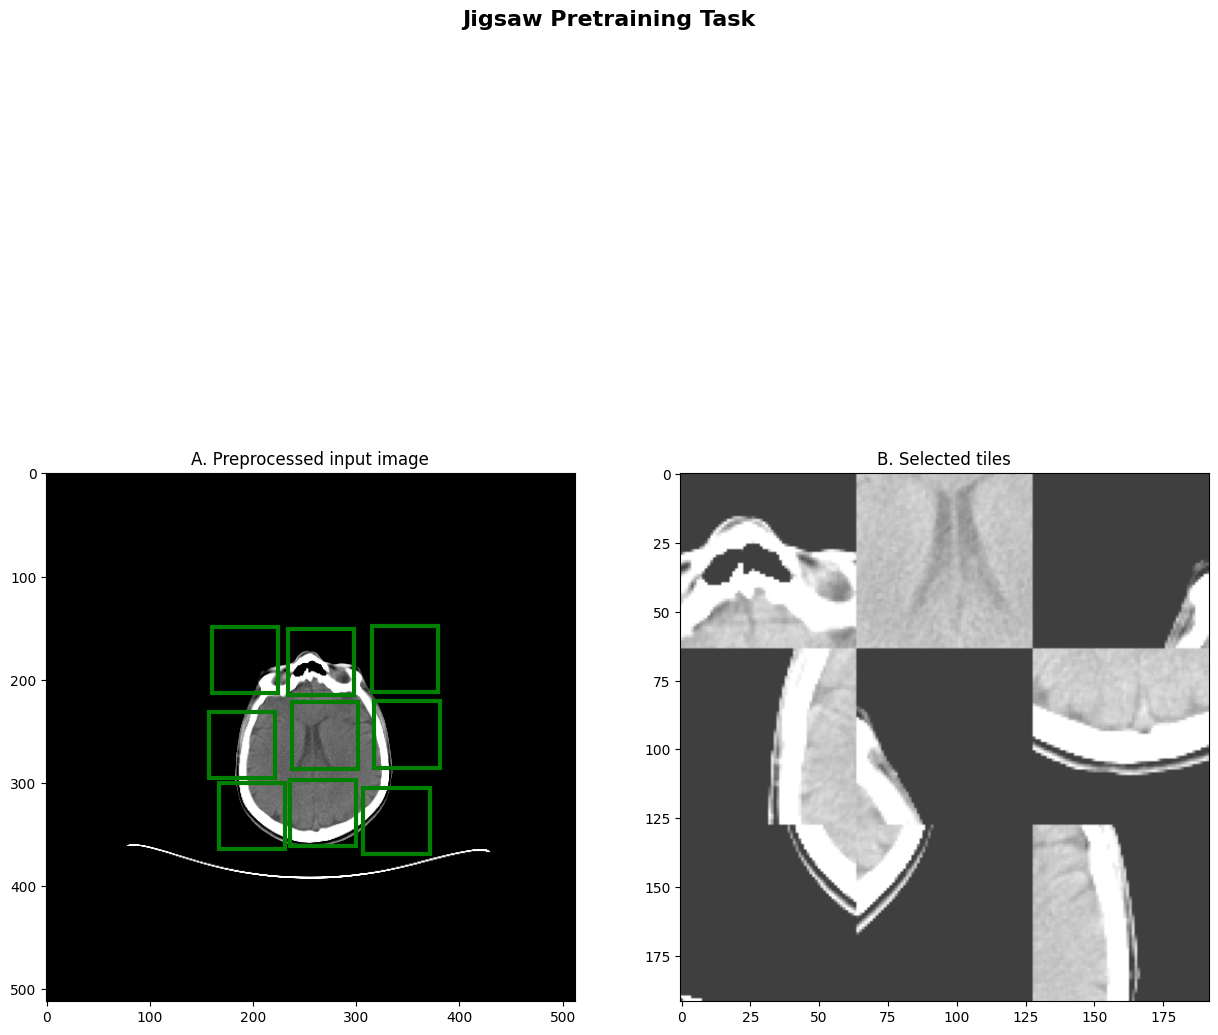

tile top left: [153 154] -- tile bottom right: [217 218]

tile top left: [162 229] -- tile bottom right: [226 293]

tile top left: [155 309] -- tile bottom right: [219 373]

tile top left: [234 162] -- tile bottom right: [298 226]

tile top left: [234 239] -- tile bottom right: [298 303]

tile top left: [237 303] -- tile bottom right: [301 367]

tile top left: [303 154] -- tile bottom right: [367 218]

tile top left: [302 233] -- tile bottom right: [366 297]

tile top left: [308 309] -- tile bottom right: [372 373]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([153, 154])

c_prime is: tensor([162, 229])

c_prime is: tensor([155, 309])

c_prime is: tensor([234, 162])

c_prime is: tensor([234, 239])

c_prime is: tensor([237, 303])

c_prime is: tensor([303, 154])

c_prime is: tensor([302, 233])

c_prime is: tensor([308, 309])

torch.Size([1, 9, 64, 64])


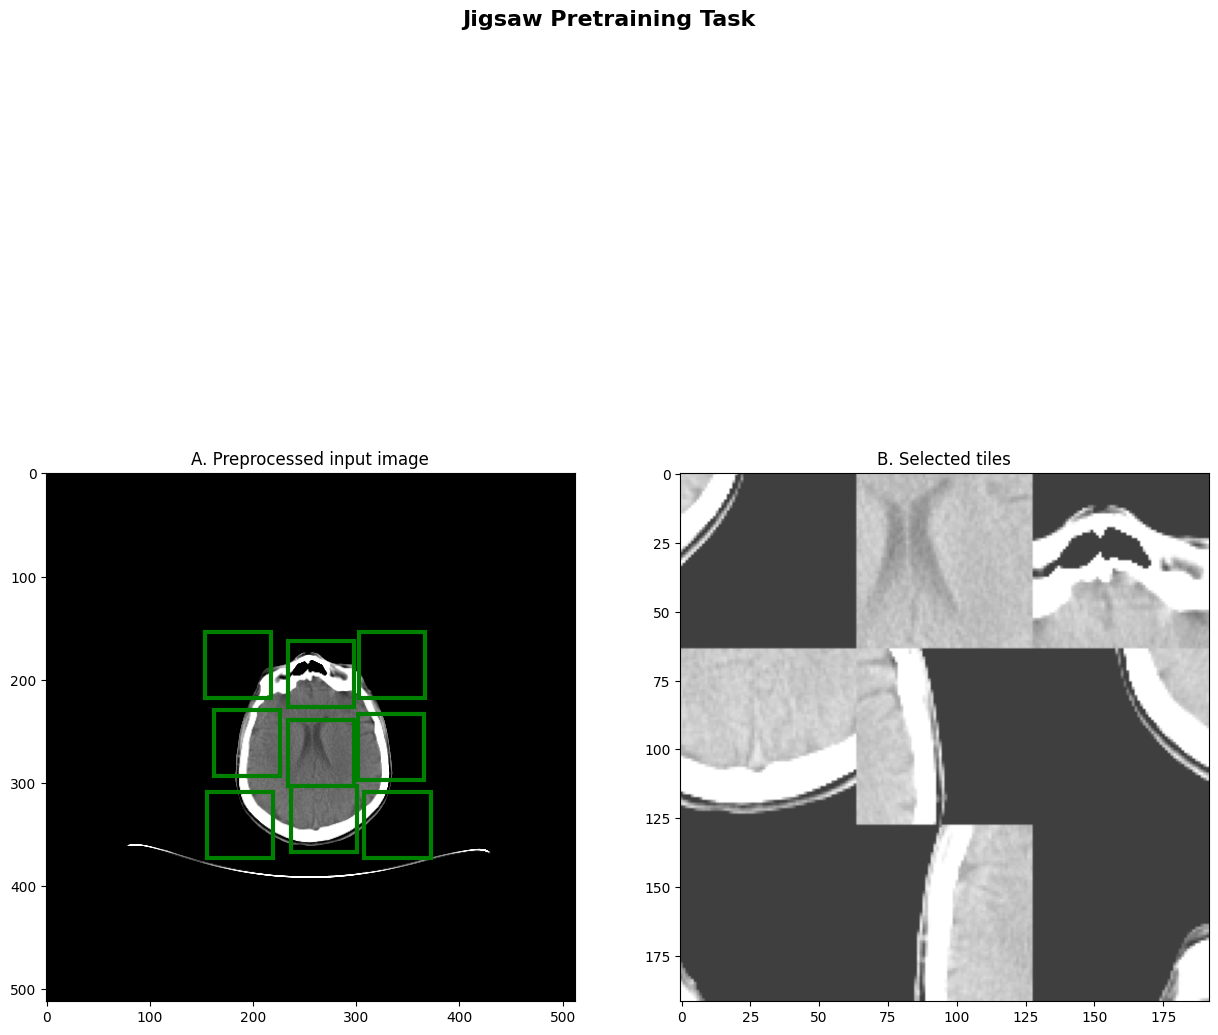

tile top left: [147 143] -- tile bottom right: [211 207]

tile top left: [152 225] -- tile bottom right: [216 289]

tile top left: [152 300] -- tile bottom right: [216 364]

tile top left: [225 149] -- tile bottom right: [289 213]

tile top left: [227 227] -- tile bottom right: [291 291]

tile top left: [221 299] -- tile bottom right: [285 363]

tile top left: [301 145] -- tile bottom right: [365 209]

tile top left: [304 225] -- tile bottom right: [368 289]

tile top left: [303 303] -- tile bottom right: [367 367]

torch.Size([1, 1, 9, 64, 64])
c_prime is: tensor([147, 143])

c_prime is: tensor([152, 225])

c_prime is: tensor([152, 300])

c_prime is: tensor([225, 149])

c_prime is: tensor([227, 227])

c_prime is: tensor([221, 299])

c_prime is: tensor([301, 145])

c_prime is: tensor([304, 225])

c_prime is: tensor([303, 303])

torch.Size([1, 9, 64, 64])


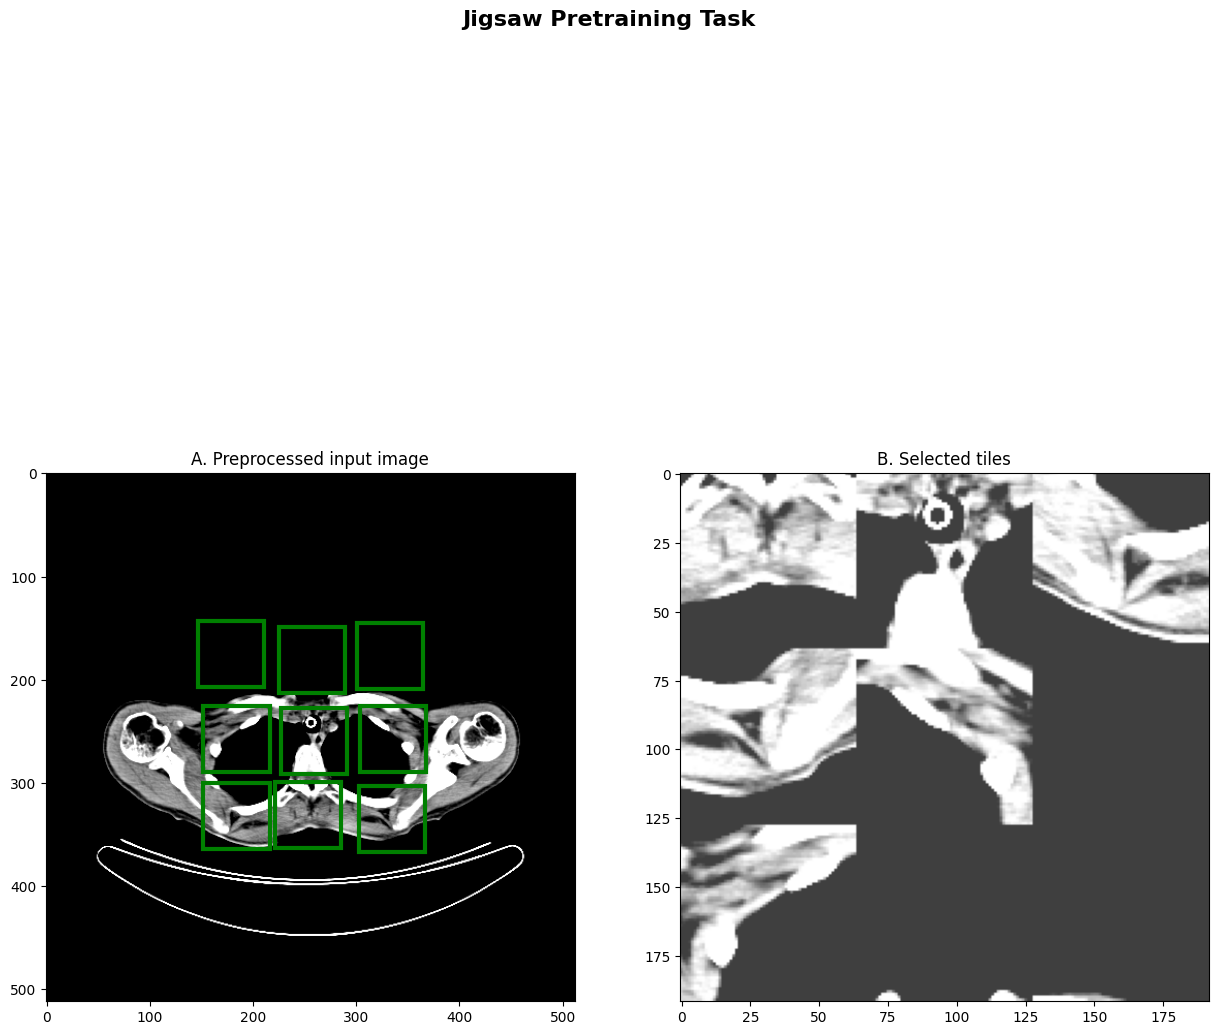

tile top left: [149 135] -- tile bottom right: [213 199]

tile top left: [145 212] -- tile bottom right: [209 276]

tile top left: [144 288] -- tile bottom right: [208 352]

tile top left: [226 139] -- tile bottom right: [290 203]

tile top left: [223 212] -- tile bottom right: [287 276]

tile top left: [220 284] -- tile bottom right: [284 348]

tile top left: [300 136] -- tile bottom right: [364 200]

tile top left: [302 212] -- tile bottom right: [366 276]

tile top left: [293 280] -- tile bottom right: [357 344]

torch.Size([1, 1, 9, 64, 64])


KeyboardInterrupt: 

<Figure size 1500x1500 with 0 Axes>

In [14]:
pretrain_task = "jigsaw"    # "jigsaw" or "felz"

if __name__ == '__main__':
    dl = create_dataloader(pretrain_task = pretrain_task)

    if pretrain_task == "felz":
        for (image, mask, img_path, slice_n, segments, metadata, super_pixels) in dl:
            raw_img = get_raw_image(img_path)

            plot_slices_and_mask(image, mask, raw_img, segments=segments, super_pixels = super_pixels)

    elif pretrain_task == "jigsaw":
        for (image, img_path, slice_n, tiles, coords, all_tiles, all_labels) in dl:
            tiles = tiles.unsqueeze(0)
            print(tiles.size())
            plot_slice_and_tiles(image.type(torch.int16), all_tiles, coords)

        